# Start



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
# from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#import some necessary packages
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cocrystal_design/utils/')
from baggingPU import BaggingClassifierPU
from pu_learning import spies
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

In [ ]:
!pip install pyod

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/X_to_PU_Performance.csv")
y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/y_to_PU_Performance.csv")

In [ ]:
X = X.iloc[:,1:]
y = y.iloc[:,1:]


X = X.squeeze('columns')
y = y.squeeze('columns')


49304 data points and 412 features
722 positive out of 49304 total


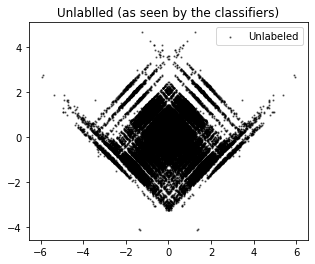

In [ ]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))


# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 3000
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0



from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_scaled_PCA=pca.fit_transform(X)

df_scaled_PCA= pd.DataFrame(df_scaled_PCA)
df_scaled_PCA.rename(columns={0:'PCA1',1:"PCA2"},inplace=True)
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

plt.figure(figsize=(5,4))
# Plot the data set, as the models will see it
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c='k', marker='.', linewidth=1, s=5, alpha=0.5, 
    label='Unlabeled'
)

plt.legend()
plt.title('Unlablled (as seen by the classifiers)')
plt.show()


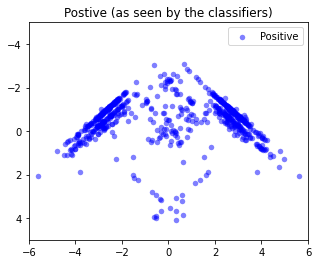

In [ ]:

plt.figure(figsize=(5,4))
# Plot the data set, as the models will see it
# plt.scatter(
#     df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
#     c='k', marker='.', linewidth=1, s=5, alpha=0.5, 
#     label='Unlabeled'
# )
plt.scatter(
    df_scaled_PCA[y==1].iloc[:,0], df_scaled_PCA[y==1].iloc[:,1], 
    c='b', marker='o', linewidth=0, s=30, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.xlim([-6, 6])
plt.ylim([5, -5])
plt.title('Postive (as seen by the classifiers)')
plt.show()

# Standard

In [ ]:
rf = RandomForestClassifier(
    n_estimators = 25,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)


# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,    # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label','output_std'])

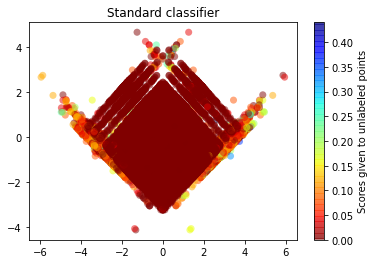

In [ ]:

# Visualize this approach's results
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

# Spy

In [ ]:
model = spies(RandomForestClassifier(n_estimators=200,max_depth =  None, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0),RandomForestClassifier(n_estimators=200,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0))
model.fit(X, y)
results['output_spies'] = model.predict_proba(X)
print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_spies'])))

Accuracy - 98.8%, AUC - 0.9969


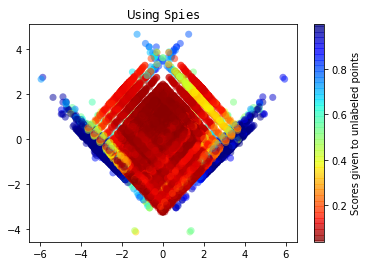

In [ ]:

# Visualize this approach's results
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c = results[y==0].output_spies, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt Spies}$')
plt.show()

# IForest

In [ ]:
from pyod.models.iforest import IForest

In [ ]:
idx = np.where(y == 1.)
iforest = IForest(n_estimators = 1000, contamination = 0.1, n_jobs = -1, behaviour='new')
iforest.fit(X.iloc[idx])
results['output_IForest'] = iforest.predict_proba(X)[:,0] 


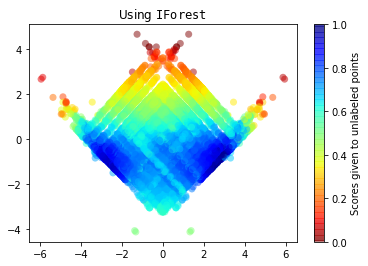

In [ ]:
# Visualize this approach's results
plt.scatter(
    df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
    c = results[y==0].output_IForest, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt IForest}$')
plt.show()


# Comparison of approache

In [ ]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
# y_bag_tree, y_bag_svc, y_spies = [], [], []
y_std, y_IForest, y_spies = [], [], []
for t in ts:
  
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )


    y_IForest.append(
        results[results.label == 0].sort_values(
            'output_IForest', ascending = False
        ).head(t).truth.mean()
    )
    # y_bag_svc.append(
    #     results[results.label == 0].sort_values(
    #         'output_bag_svc', ascending = False
    #     ).head(t).truth.mean()
    # )
    y_spies.append(
        results[results.label == 0].sort_values(
            'output_spies', ascending = False
        ).head(t).truth.mean()
    )

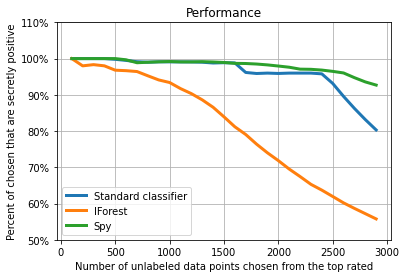

In [ ]:
# Performance graphing
plt.plot(
    ts, y_std,
    ts, y_IForest,
    # ts, y_bag_tree,
    # ts, y_bag_svc,
    ts, y_spies,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'IForest',
    'Spy'
])
ylim = plt.gca().get_ylim()

plt.title('Performance')
plt.grid()
plt.show()

# Different hide size comparison

49304 data points and 412 features
3722 positive out of 49304 total
222 positive out of 49304 total


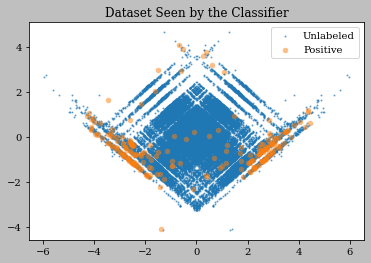

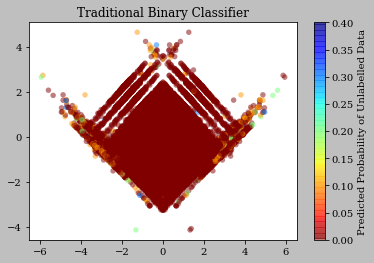

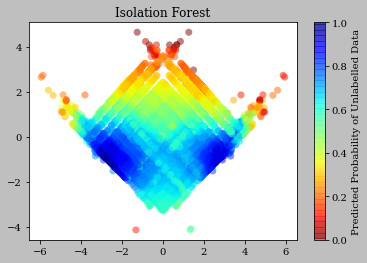

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy - 98.1%, AUC - 0.983


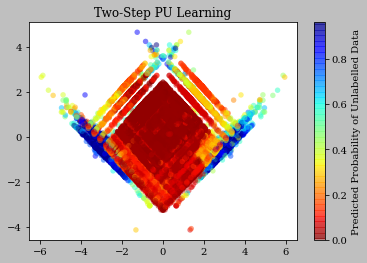

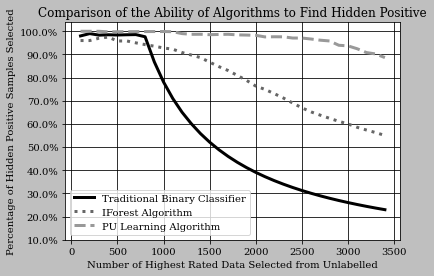

In [ ]:
for hidden_size in range(3500, 3600, 100):

    plt.style.use('grayscale')

    
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    X = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/X_to_PU_Performance.csv")
    y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cocrystal_design/data/y_to_PU_Performance.csv")

    X = X.iloc[:,1:]
    y = y.iloc[:,1:]
    y = y.squeeze('columns')
    # Check the contents of the set
    print('%d data points and %d features' % (X.shape))
    print('%d positive out of %d total' % (sum(y), len(y)))

    # Keep the original targets safe for later
    y_orig = y.copy()

    # Unlabel a certain number of data points

    y.loc[
        np.random.choice(
            y[y == 1].index, 
            replace = False, 
            size = hidden_size
        )
    ] = 0



    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    df_scaled_PCA=pca.fit_transform(X)

    df_scaled_PCA= pd.DataFrame(df_scaled_PCA)
    df_scaled_PCA.rename(columns={0:'PCA1',1:"PCA2"},inplace=True)
    # Check the new contents of the set
    print('%d positive out of %d total' % (sum(y), len(y)))


    fig = plt.figure()
    # plt.grid(b=None)


    plt.scatter(
        df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
        c='tab:blue', marker='.', linewidth=1, s=5, alpha=0.5, 
        label='Unlabeled'
    )
    plt.scatter(
        df_scaled_PCA[y==1].iloc[:,0], df_scaled_PCA[y==1].iloc[:,1], 
        c='tab:orange', marker='o', linewidth=0, s=30, alpha=0.5, 
        label='Positive'
    )
    plt.legend()
    plt.title('Dataset Seen by the Classifier')
    plt.savefig( fname = str(hidden_size)+'Dataset' ,dpi=400)
    plt.show()
  

    rf = RandomForestClassifier(
        n_estimators = 10,  # Use 1000 trees
        n_jobs = -1           # Use all CPU cores
    )
    rf.fit(X, y)


    # Store the scores assigned by this approach
    results = pd.DataFrame({
        'truth'      : y_orig,   # The true labels
        'label'      : y,    # The labels to be shown to models in experiment
        'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
    }, columns = ['truth', 'label','output_std'])

    # plt.subplot(2, 2, 2)
    # Visualize this approach's results


    plt.style.use('grayscale')

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.scatter(
        df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
        c = results[y==0].output_std, linewidth = 0, s = 30, alpha = 0.5, 
        cmap = 'jet_r'
    )
    plt.colorbar(label='Predicted Probability of Unlabelled Data')
    plt.title('Traditional Binary Classifier')
    plt.savefig( fname = str(hidden_size)+'Bin' ,dpi=400)
    plt.show()



    idx = np.where(y == 1.)
    iforest = IForest(n_estimators = 1000, contamination = 0.1, n_jobs = -1, behaviour='new')
    iforest.fit(X.iloc[idx].iloc[:,:])
    results['output_IForest'] = iforest.predict_proba(X)[:,0] 
    # Visualize this approach's results

    plt.scatter(
        df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
        c = results[y==0].output_IForest, linewidth = 0, s = 50, alpha = 0.5, 
        cmap = 'jet_r'
    )
    plt.colorbar(label='Predicted Probability of Unlabelled Data')
    plt.title('Isolation Forest')
    plt.savefig( fname = str(hidden_size)+'Iso' ,dpi=400)
    plt.show()



    model = spies(RandomForestClassifier(n_estimators=10,max_depth =  None, oob_score = True,  class_weight = 'balanced', n_jobs = -1,random_state=0),RandomForestClassifier(n_estimators=10,max_depth =  5, oob_score = True,  class_weight = 'balanced_subsample', n_jobs = -1,random_state=0))
    model.fit(X, y)
    results['output_spies'] = model.predict_proba(X)
    print('Accuracy - {0:.01%}, AUC - {1:.04}'.format((model.predict(X) == y_orig).mean(), roc_auc_score(y_orig, results['output_spies'])))


    # plt.subplot(2, 2, 3)
    # Visualize this approach's results
    
    plt.style.use('grayscale')

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.scatter(
        df_scaled_PCA[y==0].iloc[:,0], df_scaled_PCA[y==0].iloc[:,1], 
        c = results[y==0].output_spies, linewidth = 0, s = 30, alpha = 0.5, 
        cmap = 'jet_r'
    )
    plt.colorbar(label='Predicted Probability of Unlabelled Data')
    plt.title('Two-Step PU Learning')
    plt.savefig( fname = str(hidden_size)+'PU' ,dpi=400)
    plt.show()


    # Prepare for graphing the performance 
    # (i.e. the success in identifying hidden positives)
    ts = range(100, hidden_size, 100)
    # y_bag_tree, y_bag_svc, y_spies = [], [], []
    y_std, y_IForest, y_spies = [], [], []
    for t in ts:
      
        y_std.append(
            results[results.label == 0].sort_values(
                'output_std', ascending = False
            ).head(t).truth.mean()
        )

        y_IForest.append(
        results[results.label == 0].sort_values(
            'output_IForest', ascending = False
        ).head(t).truth.mean()
        )



        # y_bag_tree.append(
        #     results[results.label == 0].sort_values(
        #         'output_bag_tree', ascending = False
        #     ).head(t).truth.mean()
        # )
        # y_bag_svc.append(
        #     results[results.label == 0].sort_values(
        #         'output_bag_svc', ascending = False
        #     ).head(t).truth.mean()
        # )
        y_spies.append(
            results[results.label == 0].sort_values(
                'output_spies', ascending = False
            ).head(t).truth.mean()
        )


    plt.style.use('grayscale')
    # plt.style.use('seaborn')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # Performance graphing
    plt.plot(
        ts, y_std,
        # ts, y_bag_tree,
        # ts, y_bag_svc,
        ts, y_IForest, ':',
        ts, y_spies, '--',
        lw = 3
    )

    vals = plt.gca().get_yticks()
    counter = 0
    for i in vals:

      
      if i>1.0:
        vals = np.delete(vals,counter)

      counter += 1




    plt.yticks(vals, ['{:,.1%}'.format(v) for v in vals])
    plt.xlabel('Number of Highest Rated Data Selected from Unlabelled')
    plt.ylabel('Percentage of Hidden Positive Samples Selected')
    plt.legend([
        'Traditional Binary Classifier', 
        'IForest Algorithm',
        'PU Learning Algorithm'
    ])
    ylim = plt.gca().get_ylim()
    # plt.ylim([, 1])
    plt.title('Comparison of the Ability of Algorithms to Find Hidden Positive')
    plt.grid()


    fig.tight_layout()
    plt.savefig( fname = str(hidden_size)+'Performance' ,dpi=400, bbox_inches = 'tight')
    plt.show()


In [ ]:
vals

In [ ]:
y_spies

In [ ]:
counter = 0
for i in vals:

  
  if i>1.0:
    vals = np.delete(vals,counter)

  counter += 1


In [ ]:
vals

In [ ]:
results[results.label == 0]

In [ ]:
results[results.label == 0].sort_values(
            'output_COPOD', ascending = False
        ).head(t).truth